In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import *
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import *
from keras.layers.merge import concatenate
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [5]:
print(os.listdir("../input"))

['.DS_Store', '2015_BOE_Chiu']


In [6]:
input_path = os.path.join('..', 'input', '2015_BOE_Chiu', '2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 768
height = 496

In [4]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

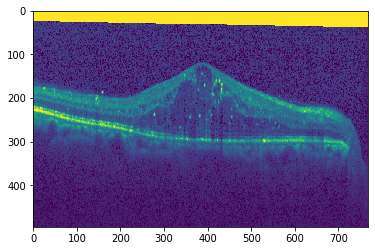

In [5]:
plt.imshow(img_array[32])

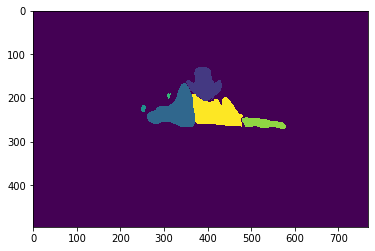

In [6]:
plt.imshow(manual_fluid_array[32])

In [7]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in paths:
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        
        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 2)]
            y += [np.expand_dims(fluid_array[idx], 2)]
        
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 496, 768, 1), (99, 496, 768, 1), (11, 496, 768, 1), (11, 496, 768, 1))

In [7]:
input_size = (height,width,1)

inputs = Input(input_size)
conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(24, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(drop5))
# up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(drop5)
# up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(conv5)
merge6 = concatenate([drop4, up6], axis=3)
# merge6 = concatenate([conv4, up6])
conv6 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(16, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis=3)
conv7 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(12, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2,up8], axis=3)
conv8 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(8, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis=3)
conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 496, 768, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 496, 768, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 496, 768, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 248, 384, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

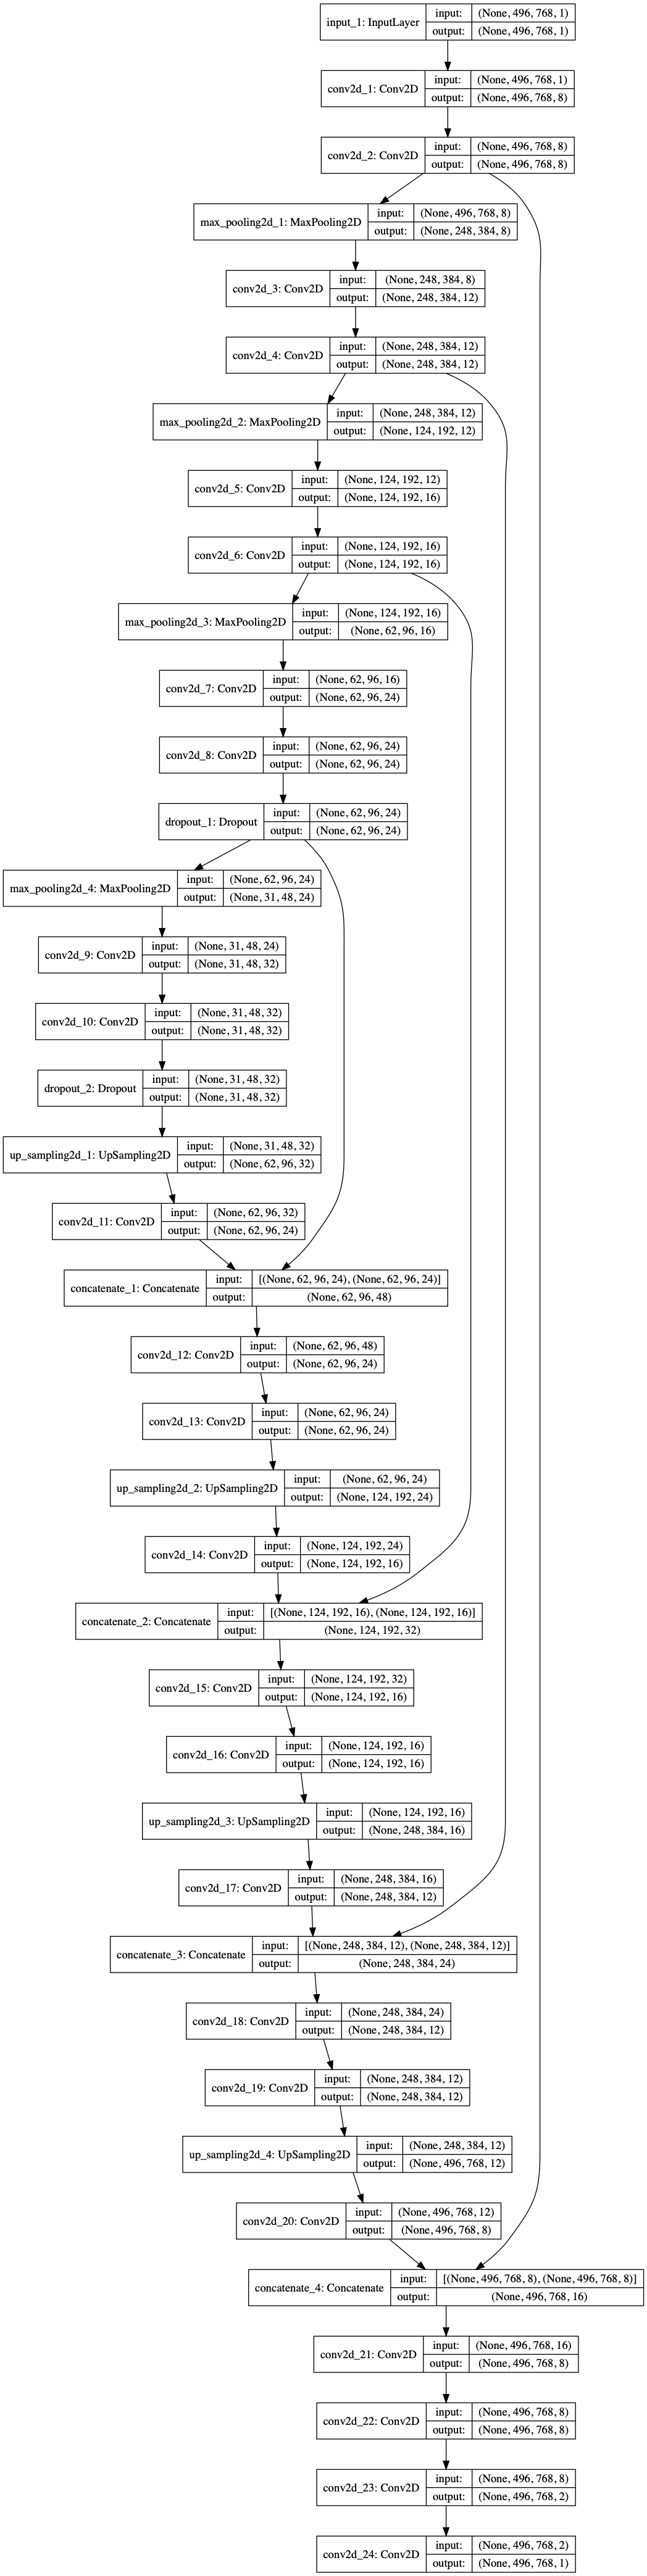

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True)

In [113]:
# input_size = (height,width,1)

# inputs = Input(input_size)
# conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
# conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# conv2 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
# conv2 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
# conv3 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# conv4 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
# conv4 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
# # drop4 = Dropout(0.5)(conv4)
# # pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# conv5 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
# conv5 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
# # drop5 = Dropout(0.5)(conv5)

# # up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(drop5)
# up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(conv5)
# # merge6 = concatenate([drop4, up6])
# merge6 = concatenate([conv4, up6])
# conv6 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

# up7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv6)
# merge7 = concatenate([conv3,up7])
# conv7 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

# up8 = Conv2DTranspose(12, (2, 2), strides=(2, 2), padding='same')(conv7)
# merge8 = concatenate([conv2,up8])
# conv8 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(12, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

# up9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8)
# merge9 = concatenate([conv1,up9])
# conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
# conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
# conv9 = Conv2D(2, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

# model = Model(inputs=[inputs], outputs=[outputs])

# model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 496, 768, 1)  0                                            
__________________________________________________________________________________________________
conv2d_339 (Conv2D)             (None, 496, 768, 8)  80          input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_340 (Conv2D)             (None, 496, 768, 8)  584         conv2d_339[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 248, 384, 8)  0           conv2d_340[0][0]                 
___________________________________________________________________________________________

In [159]:
input_size = (height,width,1)

inputs = Input(input_size)
conv1 = Conv2D(8, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(12, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(12, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(16, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(24, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(24, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
# drop4 = Dropout(0.5)(conv4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(32, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(32, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
# drop5 = Dropout(0.5)(conv5)

# up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(drop5)
up6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(conv5)
# merge6 = concatenate([drop4, up6])
merge6 = concatenate([conv4, up6])
conv6 = Conv2D(24, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(24, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv6)
merge7 = concatenate([conv3,up7])
conv7 = Conv2D(16, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(16, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2DTranspose(12, (2, 2), strides=(2, 2), padding='same')(conv7)
merge8 = concatenate([conv2,up8])
conv8 = Conv2D(12, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(12, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8)
merge9 = concatenate([conv1,up9])
conv9 = Conv2D(8, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(8, (3, 3), activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 496, 768, 1)  0                                            
__________________________________________________________________________________________________
conv2d_477 (Conv2D)             (None, 496, 768, 8)  80          input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_478 (Conv2D)             (None, 496, 768, 8)  584         conv2d_477[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_105 (MaxPooling2D (None, 248, 384, 8)  0           conv2d_478[0][0]                 
___________________________________________________________________________________________

In [44]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, to_file='model1.png', show_shapes=True)

In [167]:
# model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
# model.fit(x_train, y_train,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])

from keras.callbacks import EarlyStopping

results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=11, epochs=20)

Train on 99 samples, validate on 11 samples
Epoch 1/20
99/99 [==============================] - ETA: 4s - loss: 0.6275 - accuracy: 0.81 - ETA: 3s - loss: 0.6489 - accuracy: 0.72 - ETA: 3s - loss: 0.6473 - accuracy: 0.72 - ETA: 2s - loss: 0.6564 - accuracy: 0.67 - ETA: 2s - loss: 0.6682 - accuracy: 0.63 - ETA: 1s - loss: 0.6805 - accuracy: 0.58 - ETA: 1s - loss: 0.6776 - accuracy: 0.59 - ETA: 0s - loss: 0.6792 - accuracy: 0.58 - 5s 49ms/step - loss: 0.6745 - accuracy: 0.6009 - val_loss: 0.5559 - val_accuracy: 0.9889
Epoch 2/20
99/99 [==============================] - ETA: 4s - loss: 0.6587 - accuracy: 0.63 - ETA: 3s - loss: 0.6317 - accuracy: 0.72 - ETA: 3s - loss: 0.6409 - accuracy: 0.69 - ETA: 2s - loss: 0.6539 - accuracy: 0.65 - ETA: 2s - loss: 0.6696 - accuracy: 0.61 - ETA: 1s - loss: 0.6732 - accuracy: 0.60 - ETA: 1s - loss: 0.6562 - accuracy: 0.64 - ETA: 0s - loss: 0.6656 - accuracy: 0.61 - 5s 49ms/step - loss: 0.6725 - accuracy: 0.6009 - val_loss: 0.5048 - val_accuracy: 0.9889
Ep

In [161]:
pred = model.predict(x_val)

In [162]:
pred = (pred > 0.5).astype(np.uint8)

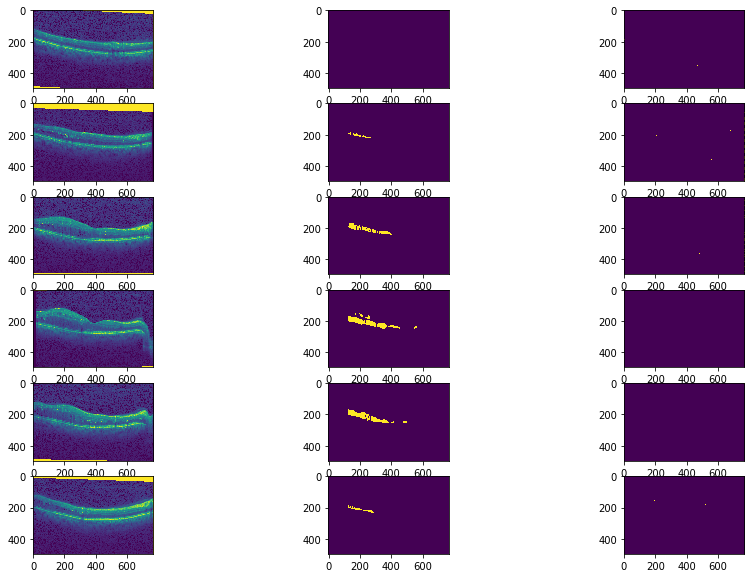

In [163]:
nrows = 6

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 10))
for i in range(nrows):
    axes[i][0].imshow(np.reshape(x_val[2*i], (496, 768)))
    axes[i][1].imshow(np.reshape(y_val[2*i], (496, 768)))
    axes[i][2].imshow(np.reshape(pred[2*i], (496, 768)))

plt.show()

In [1]:
model.evaluate(x_val, y_val)

NameError: name 'model' is not defined

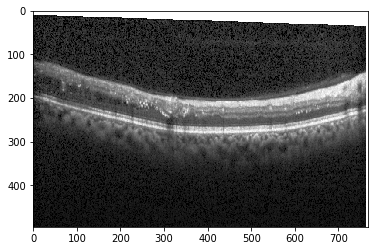

In [129]:
plt.imshow(np.reshape(x_val[10], (496, 768)), cmap='Greys_r')

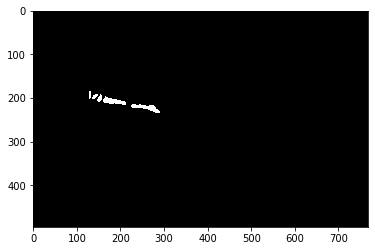

In [130]:
plt.imshow(np.reshape(y_val[10], (496, 768)), cmap='Greys_r')

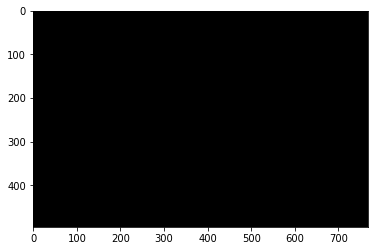

In [131]:
plt.imshow(np.reshape(pred[10], (496, 768)), cmap='Greys_r')

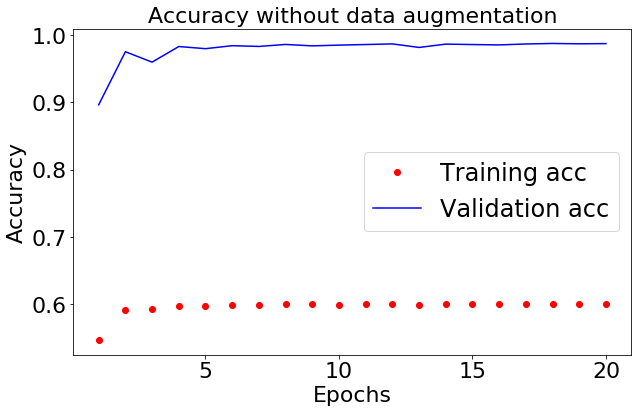

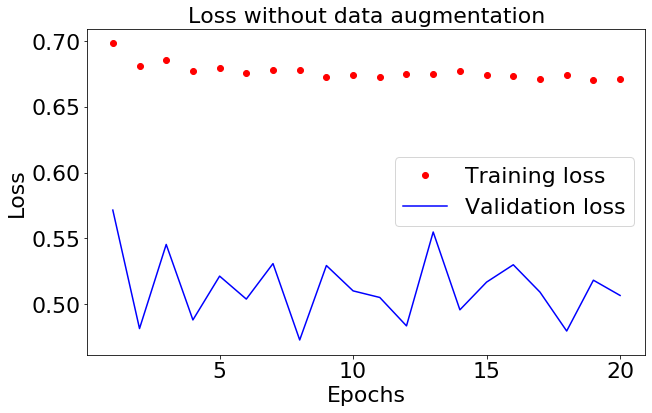

In [164]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc, 'ro', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_title('Accuracy without data augmentation', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)

figL, axL = plt.subplots(1,1, figsize=(10,6))

axL.plot(epochs, loss, 'ro', label='Training loss')
axL.plot(epochs, val_loss, 'b', label='Validation loss')
axL.set_title('Loss without data augmentation', fontsize=22)
axL.set_xlabel(r'Epochs', fontsize=22)
axL.set_ylabel(r'Loss', fontsize=22)
axL.tick_params(labelsize=22)
axL.legend(fontsize=22)